In [65]:
# Section must be included at the beginning of each new notebook. Remember to change the app name.
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('logistic_regression_adv').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip3 install numpy --user' into the console.
# If you're getting an error with another package, type 'sudo pip3 install PACKAGENAME --user'. 
# Replace PACKAGENAME with the relevant package (such as pandas, etc).
from pyspark.ml.classification import LogisticRegression

# Import data and print schema - columns is another way to view the data's features.
df = spark.read.csv('Datasets/IVS_Country.csv', header=True, inferSchema=True)
df.printSchema()
print(df.columns)

root
 |-- Pkey: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Year ending: string (nullable = true)
 |-- Airport of departure: string (nullable = true)
 |-- Purpose of visit: string (nullable = true)
 |-- Country of permanent residence: string (nullable = true)
 |-- Total visitor spend: double (nullable = true)
 |-- Total visitors: integer (nullable = true)

['Pkey', 'Year', 'Quarter', 'Year ending', 'Airport of departure', 'Purpose of visit', 'Country of permanent residence', 'Total visitor spend', 'Total visitors']


In [66]:
# Import pandas.
import pandas as pd

# Take the first five rows of data, and visualise.
pd.DataFrame(df.take(5), columns=df.columns)

,Pkey,Year,Quarter,Year ending,Airport of departure,Purpose of visit,Country of permanent residence,Total visitor spend,Total visitors
0,1,1997,4,YEDec 1997,Auckland,Business,Africa and Middle East,4.266524e+06,1684
1,2,1997,4,YEDec 1997,Auckland,Business,Australia,1.325885e+08,67277
2,3,1997,4,YEDec 1997,Auckland,Business,Canada,1.558969e+07,3596
3,4,1997,4,YEDec 1997,Auckland,Business,China,9.490118e+06,4510
4,5,1997,4,YEDec 1997,Auckland,Business,Germany,5.481106e+06,1889


In [67]:
# To visualise the first five columns, simply add transpose. 
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Pkey,1,2,3,4,5
Year,1997,1997,1997,1997,1997
Quarter,4,4,4,4,4
Year ending,YEDec 1997,YEDec 1997,YEDec 1997,YEDec 1997,YEDec 1997
Airport of departure,Auckland,Auckland,Auckland,Auckland,Auckland
Purpose of visit,Business,Business,Business,Business,Business
Country of permanent residence,Africa and Middle East,Australia,Canada,China,Germany
Total visitor spend,4.26652e+06,1.32589e+08,1.55897e+07,9.49012e+06,5.48111e+06
Total visitors,1684,67277,3596,4510,1889


In [68]:
# Oops! Forgot to assign the result to a variable. Let's try that again. Now you can see that records with null values have been removed.
df = df.na.drop()
df.show()
print("Total data points:", df.count())

+----+----+-------+-----------+--------------------+------------------+------------------------------+-------------------+--------------+
|Pkey|Year|Quarter|Year ending|Airport of departure|  Purpose of visit|Country of permanent residence|Total visitor spend|Total visitors|
+----+----+-------+-----------+--------------------+------------------+------------------------------+-------------------+--------------+
|   1|1997|      4| YEDec 1997|            Auckland|          Business|          Africa and Middle...|         4266524.07|          1684|
|   2|1997|      4| YEDec 1997|            Auckland|          Business|                     Australia|      1.325885058E8|         67277|
|   3|1997|      4| YEDec 1997|            Auckland|          Business|                        Canada|      1.558969421E7|          3596|
|   4|1997|      4| YEDec 1997|            Auckland|          Business|                         China|         9490117.52|          4510|
|   5|1997|      4| YEDec 1997|   

In [69]:
# We can use group by and count to find out how many data points we have for each class in our predictor. 
df.groupby('year').count().toPandas()

,year,count
0,2003,530
1,2007,568
2,2018,155
3,2015,603
4,2006,565
5,2013,587
6,1997,116
7,2014,605
8,2004,554
9,1998,472


In [70]:
# Using a for loop to find all columns that belong to the integer data type. 
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']

# Selecting the numeric features, generating summary statistics, and converting to a Pandas DataFrame.
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pkey,11292,8609.705897980872,4917.03995600964,1,17056
Year,11292,2007.9382748848743,5.880289393162935,1997,2018
Quarter,11292,2.4991144172865747,1.1292752985276613,1,4
Total visitors,11292,15576.741232731138,33229.303734004156,1,314584


In [71]:
# Using a for loop to find all columns that belong to the integer data type. 
numeric_features = [t[0] for t in df.dtypes if t[1] == 'double']

# Selecting the numeric features, generating summary statistics, and converting to a Pandas DataFrame.
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Total visitor spend,11292,5.09246119696264E7,1.0193863986366412E8,2.4,1.235333092E9


In [72]:
# Import the relevant packages.
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)

# First create a string indexer which converts every string into a number
# A number will be assigned to every category in the column.
yearending_indexer = StringIndexer(inputCol='Year ending',outputCol='yearendingIndex')
airport_indexer = StringIndexer(inputCol='Airport of departure',outputCol='airportIndex')
purpose_indexer = StringIndexer(inputCol='Purpose of visit',outputCol='purposeIndex')
country_indexer = StringIndexer(inputCol='Country of permanent residence',outputCol='label')


In [73]:
# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# Multiple columns are collapsed into one. 
# This makes it easier to process when you have multiple classes.
yearending_encoder = OneHotEncoder(inputCol='yearendingIndex',outputCol='yearendingVec')
airport_encoder = OneHotEncoder(inputCol='airportIndex',outputCol='airportVec')
purpose_encoder = OneHotEncoder(inputCol='purposeIndex',outputCol='purposeVec')


In [74]:
# And finally, using vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['yearendingVec', 'airportVec', 'purposeVec', 'Pkey', 'Year', 'Quarter', 'Total visitor spend', 'Total visitors'], outputCol="features")

In [76]:
from pyspark.ml import Pipeline

# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[yearending_indexer, airport_indexer, purpose_indexer, country_indexer, yearending_encoder, airport_encoder, purpose_encoder, assembler])

print("Total data points:", df.count())

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(df)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(df)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'features')




Total data points: 11292


In [83]:
from pyspark.ml.classification import LogisticRegression

# Split our data. Note that the new DataFrame is being used.
train_data, test_data = pipe_df.randomSplit(weights=[0.7,0.3])

#weights = [.7, .3]
#seed = 42 # seed=0L
# Use randomSplit with weights and seed
#train_data, test_data = pipe_df.randomSplit(weights, seed)

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 7994
Test Dataset Count: 3298


In [93]:
# Importing the LR package.
from pyspark.ml.regression import LinearRegression

# Instantiate the instance.
lr = LinearRegression(featuresCol='features', labelCol='label')

# Fit the training data.
lr_model = lr.fit(train_data)

# Print the coefficients.
print("Coefficients: " + str(lr_model.coefficients) + "\n")


# Print the intercept.
print("Intercept: " + str(lr_model.intercept) + "\n")

# Summarise the model and print out some evaluation metrics.
training_summary = lr_model.summary

# Print RMSE. 
print("RMSE: " + str(training_summary.rootMeanSquaredError))

# Print R2.
print("R2: " + str(training_summary.r2))


Coefficients: [-427.80799947843366,-52.31680058602364,-106.41190197604368,1222.0551554557628,-542.1393045176164,-515.4508929797214,-488.58635557198306,-433.9568437453004,1.6362625174330396,-25.456477118195632,-455.2319719545229,-374.1457008204606,1276.3298224357327,-79.56229831496714,1303.48761997631,-461.43827771217815,1248.934454777955,-400.9745032691134,1194.726320207825,1466.7903154482847,-346.67180972477405,-298.22705466263875,-210.81026678896706,165.15935995355034,-270.7137202969096,1439.400145034349,137.7832413576748,-156.71568623829864,1493.6175700362453,219.27301601693082,-189.5798550697626,110.50573271610526,-183.74866410207864,-243.76014944724187,191.90964926276536,1412.0786172639064,-237.91078850039588,-129.47762071149626,-352.5829927951826,273.21799510257466,1384.635588948495,-162.53869233899457,1357.8239692187028,29.121836843267605,-292.2546244790457,-406.82179289509327,1575.100567189061,-265.0190421889495,83.35057575716324,-325.20677345289164,-379.8512435664283,-102.3838

In [94]:
train_data.describe().show()

+-------+-----------------+
|summary|            label|
+-------+-----------------+
|  count|             7994|
|   mean|5.366149612209157|
| stddev|3.623727360828956|
|    min|              0.0|
|    max|             12.0|
+-------+-----------------+



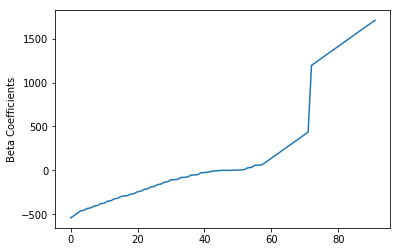

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()